In [1]:
%matplotlib inline
#(env)$ python3 -m ipykernel install --user --name=env
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import sensitivity_calculator as sens
from scipy.optimize import minimize
import sys
sys.path.append('/root/')
import pcl_actpol_utility_v4 as pau
import emcee
import corner
import tqdm
def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4
#range for power spectra
ells = np.arange(2, 8000)
#parameters for fgspectra
par = {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.7,
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_p": 6.90,
    "beta_p": 2.20,
    "a_c": 4.90,
    "beta_c": 2.20,
    "n_CIBC": 1.20,
    "xi": 0.1,
    "a_s": 3.10,
    "a_g": 2.80,
}
# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)
# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

###############################################################################################333
#use sensitivity calculator 
inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.86, 0.86, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.5e+10, 6.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.10e+11, 3.50e+11, 2.80e+11, 2.20e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")
#spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=False)
#print(spillEfficiency)
spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
#print(spillEfficiency)
# spillEfficienc#y = np.array([0.8,0.5,0.7,0.95,0.5])
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
outputs = calculate(45) #45 degree angle
#get noise from sens, by l, temp noise, and pol noise
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs)
dl = ell*(ell+1)/(2*np.pi)
#get sky fraction fsky
NSIDE = 1024
hitmap_path = "~/mask_share/ccat_uniform_coverage_nside" + str(NSIDE) + "_201021.fits"
mask_path = "~/mask_share/nside" + str(NSIDE) + "_lat_cut_b10_230619.fits"
hitm = hp.read_map(hitmap_path)
maskm = hp.read_map(mask_path)
#hp.mollview(hitm*maskm)
#hp.mollview(maskm)
fsky = np.sum(hitm*maskm)/len(hitm) 
fsky = get_hivon_fsky(hitm*maskm)
print('fsky=%.4f'%fsky)

fsky=0.4988


In [2]:
#SO noise curves
from so_models_v3 import SO_Noise_Calculator_Public_v3_1_1 as SO_noise
mode = 'baseline'
so_fsky = 0.4
lat = SO_noise.SOLatV3point1(mode,survey_years=5.,survey_efficiency = 0.2*0.85)
lat_lmax = 10000
so_freq_list = np.array([27, 39, 93, 145, 225, 280])

ell_LA, N_ell_LA_T_full,N_ell_LA_P_full = lat.get_noise_curves(
        so_fsky, lat_lmax, 1, full_covar=False, deconv_beam=True)
'''
for curves, labels, title in zip([N_ell_LA_T_full], [so_freq_list], ["SO Noise Curves (T)"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell_LA, curve, label=str(int(label))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**3)
    plt.xlabel('$\ell$',fontsize=18)
    plt.ylabel('$N_\ell [\mu K^2]$',fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

ccat_freq_list = np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11])

for curves, labels, title in zip([N_ell_T_full], [ccat_freq_list], ["CCAT Noise Curves (T)"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell, curve, label=str(int(label/1e9))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**3)
    plt.xlabel('$\ell$',fontsize=18)
    plt.ylabel('$N_\ell [\mu K^2]$',fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()
'''

'\nfor curves, labels, title in zip([N_ell_LA_T_full], [so_freq_list], ["SO Noise Curves (T)"]):\n    for curve, label in zip(curves, labels):\n        plt.plot(ell_LA, curve, label=str(int(label))+\' GHz\')\n    plt.yscale(\'log\')\n    plt.xscale(\'log\')\n    plt.xlim(10**2, 10**4)\n    plt.ylim(10**-5, 10**3)\n    plt.xlabel(\'$\\ell$\',fontsize=18)\n    plt.ylabel(\'$N_\\ell [\\mu K^2]$\',fontsize=18)\n    plt.xticks(fontsize=16)\n    plt.yticks(fontsize=16)\n    plt.title(title)\n    plt.legend(loc=\'upper right\')\n    plt.grid()\n    plt.show()\n\nccat_freq_list = np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11])\n\nfor curves, labels, title in zip([N_ell_T_full], [ccat_freq_list], ["CCAT Noise Curves (T)"]):\n    for curve, label in zip(curves, labels):\n        plt.plot(ell, curve, label=str(int(label/1e9))+\' GHz\')\n    plt.yscale(\'log\')\n    plt.xscale(\'log\')\n    plt.xlim(10**2, 10**4)\n    plt.ylim(10**-5, 10**3)\n    plt.xlabel(\'$\\ell$\',fontsize=18)\n 

In [3]:
#FTS resolution generator
def fts_res(centers):
    f=1000.000
    del_f =1.000
    ratio = del_f/f

    res = ratio * centers

    #print(res)
    return np.round(res, 4)

fts_res(1000)

1.0

N_l: [[6.24596249e+04 1.51105460e+04 5.52070875e+03 ... 8.79004842e-03
  8.80303528e-03 8.81604262e-03]
 [7.85657598e+05 1.90070180e+05 6.94430060e+04 ... 1.68935653e-04
  1.69036096e-04 1.69136608e-04]
 [3.48328283e+07 8.42692971e+06 3.07881679e+06 ... 2.11909123e-04
  2.11967443e-04 2.12025789e-04]
 [2.04324004e+08 4.94310706e+07 1.80598642e+07 ... 9.14962263e-04
  9.15160558e-04 9.15358930e-04]]
[ 93. 145. 225. 280.]
[0, 1, 2, 3, 4, 5, 6]
['$a_{\\mathrm{kSZ}}$', '$a_p$', '$a_{\\mathrm{tSZ}\\times\\mathrm{CIB}}$', '$a_s$', '$a_g$', '$a_{\\mathrm{tSZ}}$', '$a_c$']


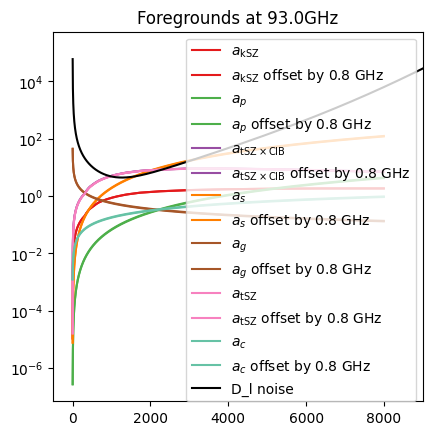

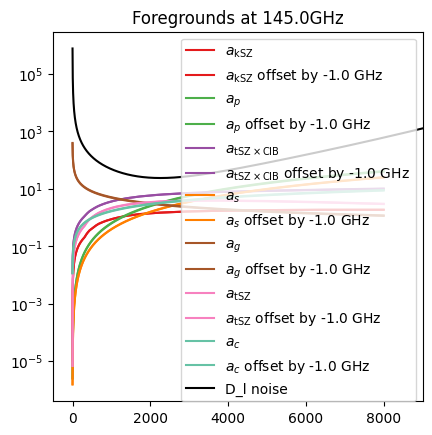

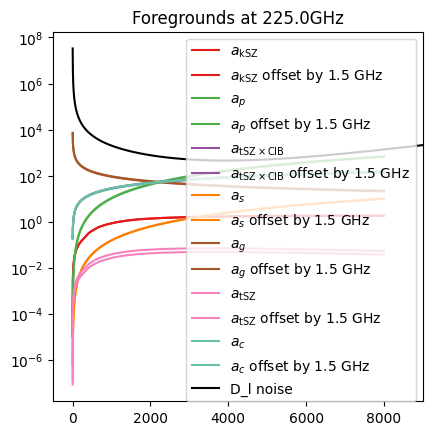

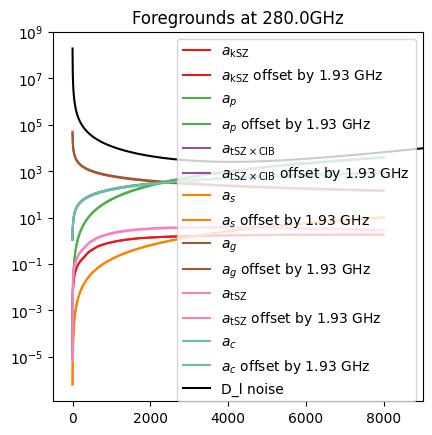

In [4]:
#Build signal and noise spectra
ccat_freq_list = np.array([850, 410, 350, 280, 220])
so_freq_list = np.array([27, 39, 93, 145, 225, 280])
#band centers to consider
#centerfreqs_full = np.concatenate((ccat_freq_list,so_freq_list))
#print(centerfreqs_full)
#frequency indices from sensitivity_calc
#[8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]
#    0          1        2         3         4
#frequency indices from SO freq list
#[25.7, 38.9, 92, 147.5, 225.7, 285.4]
#   0     1    2    3      4     5
#######################################s
ccat_center_indices = []#[1,2,3,4]
so_center_indices = [2,3,4,5]
#######################################
N_l_ccat = np.array([N_ell_T_full[i] for i in ccat_center_indices]) #noise curves from sens/CCAT
N_l_so = np.array([N_ell_LA_T_full[i] for i in so_center_indices]) #noise curves from SO

N_l = np.concatenate([arr for arr in [N_l_ccat, N_l_so] if len(arr) > 0])
print(f"N_l: {N_l}")
###########################################################################
ccat_freqs = np.array([ccat_freq_list[i] for i in ccat_center_indices])
so_freqs = np.array([so_freq_list[i] for i in so_center_indices])
centerfreqs = np.concatenate((ccat_freqs,so_freqs))
n_freq = len(centerfreqs)
print(centerfreqs)

#generate spectra as seen by the center frequencies
C_l_full = get_fg_model(centerfreqs, ells, par)
#C_l[foreground spectrum index][center frequency index1, center frequency index2]
#spectra ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c'] #spectra
#           0       1       2       3     4      5      6
###########################################
fore_indices = [0,1,2,3,4,5,6] #[5,0,6,3]  #
############################################
C_l = [C_l_full[i] for i in fore_indices]
n_fore = len(C_l)
print(fore_indices)

#mismatch/offset frequencies
############################################
ccat_offset = []#fts_res(ccat_freqs)
so_offset = [0.8,-1,1.5,1.93]
###########################################
offset = np.concatenate((ccat_offset,so_offset))
offset_centerfreqs = np.concatenate([(ccat_freqs + ccat_offset) if len(ccat_freqs) > 0 else [], (so_freqs + so_offset) if len(so_freqs) > 0 else []])
C_l_offset_full = get_fg_model(offset_centerfreqs, ells, par)
C_l_offset = [C_l_offset_full[i] for i in fore_indices]

'''
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_c": 4.90,
    "a_s": 3.10,
'''
#maps to get_fg_model  output
a_true_full = {
    0: 1.60,  # a_kSZ
    1: 6.90,  # a_p
    2: 0.10,  # xi_tSZxCIB
    3: 3.10,  # a_s
    4: 2.80,  # a_g
    5: 3.30,  # a_tSZ
    6: 4.90,  # a_c
}
'''
# a_true_full = {
#     0: 1.0,  # a_kSZ
#     1: 1.0,  # a_p
#     2: 1.0,  # tSZxCIB
#     3: 1.0,  # a_s
#     4: 1.0,  # a_g
#     5: 1.0,  # a_tSZ
#     6: 1.0,  # a_c
# }
'''
a_true = [a_true_full[i] for i in fore_indices]
#print(a_true)
#mapps to get_fg_model output
labels_full = [
    r"$a_{\mathrm{kSZ}}$", 
    r"$a_p$", 
    r"$a_{\mathrm{tSZ}\times\mathrm{CIB}}$", 
    r"$a_s$", #radio
    r"$a_g$", #dust
    r"$a_{\mathrm{tSZ}}$", 
    r"$a_c$"
]
labels = [labels_full[i] for i in fore_indices]
print(labels)

dcolors = [
    '#e41a1c',  # red
    '#4daf4a',  # green
    '#984ea3',  # purple
    '#ff7f00',  # orange
    '#a65628',  # brown
    '#f781bf',  # pink
    '#66c2a5',   # teal
    '#4b0082',  # indigo
    '#2e8b57',  # sea green
    '#800000',  # maroon
    '#3b3b98',  # dark indigo
    '#5d3fd3',  # dark violet
]

for f in range(n_freq):
    for s in range(n_fore):
        plt.plot(C_l[s][(f,f)], label=labels[s], color=dcolors[s])
        plt.plot(C_l_offset[s][(f,f)], label=f"{labels[s]} offset by {offset[f]} GHz", color=dcolors[s])
    plt.plot(N_l[f]*dl, label="D_l noise", color='black')
    plt.legend(loc = 'upper right')
    plt.yscale('log')
    plt.xlim(-500,9000)
    #plt.ylim(10e-3,10e3)
    plt.title(f"Foregrounds at {centerfreqs[f]}GHz")
    plt.gca().set_box_aspect(1)
    plt.show()


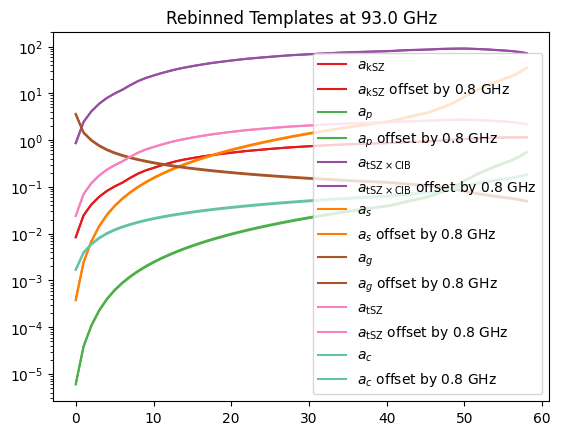

In [5]:
#from pcl_actpol_utility
def read_binfile(path,lcut=100000):
   lbands = np.array(np.genfromtxt('%s'%path)[:,:2],dtype='int')
   if len(np.where(lbands[:,1]>lcut)[0]) != 0:
      lbands = lbands[:len(lbands)-len(np.where(lbands[:,1]>lcut)[0])]
   if lbands[0,0] == 0:
      lbands[0,0] = 2
   return lbands

def get_lbands_all(lbands):
   nbins = len(lbands)
   lmax = lbands[-1, -1]
   ell = np.arange(lmax + 1)
   dl = ell*(ell+1)/(2*np.pi)

   band = np.zeros(nbins)
   ell_bin = np.zeros(nbins)

   for i in range(nbins):
      band[i] = (lbands[i,1]-lbands[i,0])/2.
      ell_bin[i] = (lbands[i,0]+lbands[i,1])/2.

   return (ell_bin, band, nbins, lmax, ell, dl)

lmax_cut = 8000
binfile = '/root/BIN_ACTPOL_50_4_SC_low_ell'
lbands = read_binfile(binfile, lcut=lmax_cut) #bin limits in l
(ell_bin, band, n_bins, lmax, elxx, dxx) = get_lbands_all(lbands)
#ell_bin = bin centers
#band = bandwidth/2

#eq 2.5 in steve paper https://arxiv.org/pdf/1509.05934
nu_b = (2*ell_bin+1)*(2*band)*so_fsky ######################### using SO fsky 
#plt.plot(nu_b, label="nu_b")

g_fac = pau.get_analytic_var_cross(fsky, ell_bin, band)
#plt.plot( 1/g_fac**2, label="nu_b from g_fac")

N_b = {}

# Rebin noise
for f1 in range(n_freq):
    N_b[f1] = np.zeros(n_bins)
    for i in range(n_bins):
        lmin, lmax = lbands[i]
        lrange = np.arange(lmin, lmax)
        D_N_l = N_l * dl
        N_b[f1][i] = np.mean(D_N_l[f1][lrange])


def rebin_C(tC_l):
   tC_b = {}
   for s in range(n_fore):
      tC_b[s] = {}
      for f1 in range(n_freq):
         for f2 in range(n_freq):
               tC_b[s][f1, f2] = np.zeros(n_bins)
               for i in range(n_bins):
                  lmin, lmax = lbands[i]
                  lrange = np.arange(lmin, lmax)
                  ################################################################## a_true means divide out the true amplitude
                  tC_b[s][f1, f2][i] = np.mean(tC_l[s][f1, f2][lrange]) / a_true[s]
                  ################################################################################ remove to fit to 1 instead (update a true)
   return tC_b

C_b = rebin_C(C_l)
C_b_offset = rebin_C(C_l_offset)

for s in range(n_fore):
      plt.plot(C_b[s][(0,0)], label=labels[s], color=dcolors[s])
      plt.plot(C_b_offset[s][(0,0)], label=f"{labels[s]} offset by {offset[0]} GHz", color=dcolors[s])

#plt.plot(N_b[0], label='noise')
plt.legend()
plt.yscale('log')
plt.title(f"Rebinned Templates at {centerfreqs[0]} GHz")
plt.show()

10


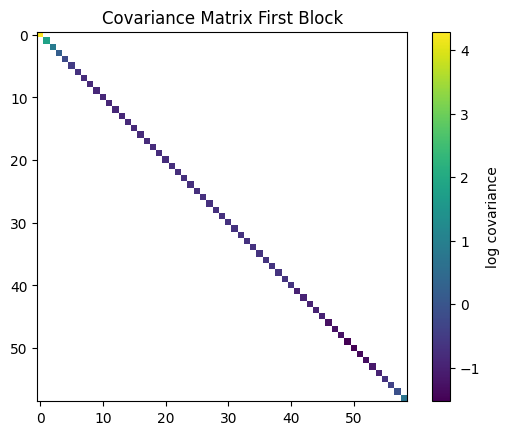

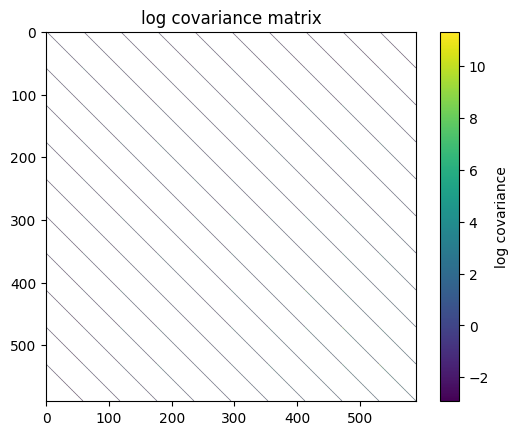

cov shape (590, 590)


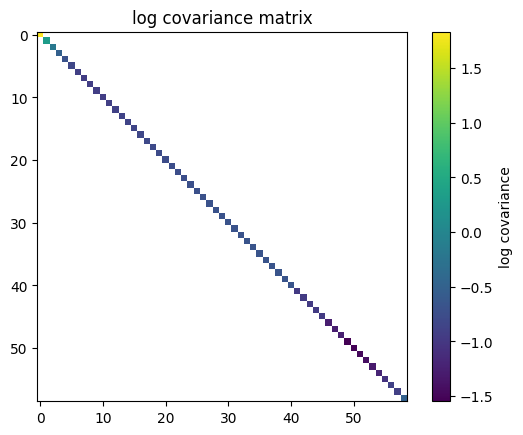

'\nplt.imshow((cov_total_full), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'covariance\')\nplt.title("covariance matrix")\nplt.show()\n\ndef cov2corr(cov):\n    stddev = np.sqrt(np.diag(cov))\n    corr = cov / np.outer(stddev, stddev)\n    np.fill_diagonal(corr, 1.0)\n    return corr\n\ncorr_matrix = np.corrcoef(cov_total_full)\nplt.imshow(np.log10(corr_matrix), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'log correlation\')\nplt.title("log correlation_matrix")\nplt.show()\nplt.imshow((corr_matrix), cmap=\'viridis\')#, vmin=vmin, vmax=vmax)\nplt.colorbar(label=\'correlation\')\nplt.title("correlation_matrix")\nplt.show()\n'

In [6]:
freq_pairs = []
pair_index = {}
k = 0
for f1 in range(n_freq):
    for f2 in range(f1, n_freq):
        freq_pairs.append((f1, f2))
        pair_index[(f1, f2)] = k
        pair_index[(f2, f1)] = k
        k += 1
n_pairs = len(freq_pairs)
print(n_pairs)

#######################################################################################
#function that automatically adds only auto spectra noise for a given frequency pair
def sig_noise(f1, f2):
    C_total = sum(C_b[s][f1, f2] for s in range(n_fore)) # sum C_b
    if f1 == f2: #only if this term has an auto spectra include noise
        C_total += N_b[f1]
    return C_total

######################################################################################
#returns correct-looking covmat
cov_matrix = np.zeros((n_bins, n_pairs, n_pairs))
for a in range(n_freq):
    for b in range(n_freq):
        for c in range(n_freq):
            for d in range(n_freq):
                i = pair_index[(a, b)]
                j = pair_index[(c, d)]
                c_ac = sig_noise(a, c)
                c_bd = sig_noise(b, d)
                c_ad = sig_noise(a, d)
                c_bc = sig_noise(b, c)
                for bin in range(n_bins):
                    cov_matrix[bin, i, j] = (1 / nu_b[bin]) * (c_ac[bin]*c_bd[bin] + c_ad[bin]*c_bc[bin])
                cov_matrix[:, j, i] = cov_matrix[:, i, j]

#form cov_matrix[bin, fpair_1, fpair_2]
block = [[np.zeros((n_bins, n_bins)) for j in range(n_pairs)] for i in range(n_pairs)]

# Fill only the diagonal of each (n_bins × n_bins) block from cov_matrix
for i in range(n_pairs):
    for j in range(n_pairs):
        for b in range(n_bins):
            block[i][j][b, b] = cov_matrix[b, i, j]
  
blockshow = block[0][0]
plt.imshow(np.log10(blockshow), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("Covariance Matrix First Block")
plt.show()

#arrange blocks into full matrix
cov_total_full = np.zeros((n_bins * n_pairs, n_bins * n_pairs))
for i in range(n_pairs):
    for j in range(n_pairs):
        #location in full matrix
        row_start = i * n_bins
        row_end = (i + 1) * n_bins
        col_start = j * n_bins
        col_end = (j + 1) * n_bins

        cov_total_full[row_start:row_end, col_start:col_end] = block[i][j]

#####################################################################

plt.imshow(np.log10(cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("log covariance matrix")
plt.show()

print(f"cov shape {np.shape(cov_total_full)}")


cov_total_full2 = np.diag(2*1/nu_b*(C_b[0][0,0] + N_b[0])**2)
                          
plt.imshow(np.log10(blockshow-cov_total_full2), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("log covariance matrix")
plt.show()
'''
plt.imshow((cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='covariance')
plt.title("covariance matrix")
plt.show()

def cov2corr(cov):
    stddev = np.sqrt(np.diag(cov))
    corr = cov / np.outer(stddev, stddev)
    np.fill_diagonal(corr, 1.0)
    return corr

corr_matrix = np.corrcoef(cov_total_full)
plt.imshow(np.log10(corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log correlation')
plt.title("log correlation_matrix")
plt.show()
plt.imshow((corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='correlation')
plt.title("correlation_matrix")
plt.show()
'''

In [7]:
labels_f = labels_full + [rf"$\Delta\nu^{{{freq:.0f}}}_{{\mathrm{{band}}}}$" for freq in centerfreqs]
print(labels_f)
print(a_true)
a_true_f = a_true + [freq for freq in centerfreqs]
print(a_true_f)

['$a_{\\mathrm{kSZ}}$', '$a_p$', '$a_{\\mathrm{tSZ}\\times\\mathrm{CIB}}$', '$a_s$', '$a_g$', '$a_{\\mathrm{tSZ}}$', '$a_c$', '$\\Delta\\nu^{93}_{\\mathrm{band}}$', '$\\Delta\\nu^{145}_{\\mathrm{band}}$', '$\\Delta\\nu^{225}_{\\mathrm{band}}$', '$\\Delta\\nu^{280}_{\\mathrm{band}}$']
[1.6, 6.9, 0.1, 3.1, 2.8, 3.3, 4.9]
[1.6, 6.9, 0.1, 3.1, 2.8, 3.3, 4.9, 93.0, 145.0, 225.0, 280.0]


In [18]:
######################################################## MCMC ###############################################
#invert cov matrix
cov_inv = np.linalg.inv(cov_total_full)
sign, logdet = np.linalg.slogdet(cov_total_full)

#generate mock data vector
signal = np.zeros((n_bins, n_pairs))
for s in range(n_fore):
    for i, (f1, f2) in enumerate(freq_pairs):
        signal[:, i] += a_true[s] * C_b[s][f1, f2]

def log_likelihood(theta, T_templates, data, cov_inv, logdet):
    model = sum(a_s * T_templates[s] for s, a_s in enumerate(theta)) #sum_nu(a*template(nu))
    delta = data - model #mock data vector for all bins and freq pairs
    return -0.5 * (delta @ cov_inv @ delta) # + logdet) #0.5*chi^2+0.5*logdet(covmat)

def log_prior(theta):
    # flat prior
    if np.all((0.0 < theta) & (theta < 9.0)):
        return 0.0
    return -np.inf

def log_probability(theta, T_templates, data, cov_inv, logdet):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_templates, data, cov_inv, logdet)

def run_emcee(C_b_torun, plot=True):
    #make template, HERE IS WHERE OFFSET IS ENFORCED
    T_templates = {}
    for s in range(n_fore):
        #make a template for each foreground spectrum
        T = np.zeros((n_bins, n_pairs))
        for idx, (f1, f2) in enumerate(freq_pairs):  
            ######################################################
            T[:, idx] = C_b_torun[s][f1, f2].copy()    #change between C_b and C_b_offset
            ########################################################
        T_templates[s] = T.flatten()
    
    #generate from fiducial C_b and cov matrix
    mock_data = np.random.multivariate_normal(mean=signal.flatten(), cov=cov_total_full)
    
    ndim = n_fore
    nwalkers = 64
    initial = np.array(a_true) + 0.01 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability,
        args=(T_templates, mock_data, cov_inv, logdet),
    )
    sampler.run_mcmc(initial, 2000, progress=True)

    samples = sampler.get_chain(discard=100, thin=2, flat=True)
    #tau = sampler.get_autocorr_time()
    #rint("Autocorrelation times:", tau)

    if plot:
        #trace plots
        chains = sampler.get_chain()
        n_steps, n_walkers, ndim = chains.shape

        fig, axes = plt.subplots(ndim, 1, figsize=(10, 2.5 * ndim), sharex=True)

        for i in range(ndim):
            ax = axes[i]
            for walker in range(n_walkers):
                ax.plot(chains[:, walker, i], alpha=0.5, lw=0.5)
            ax.set_ylabel(labels[i])
            ax.axhline(a_true[i], color='r', linestyle='--', label=labels[i])
            ax.legend(loc='upper right')

        plt.suptitle("MCMC Trace Plots", fontsize=16)
        plt.tight_layout()
        plt.show()

        #Plot the corner with truths and titles
        figure = corner.corner(
            samples,
            labels=labels,
            truths=a_true,
            label_kwargs={"fontsize": 14},
            show_titles=True,
            title_fmt=".3f",
            title_kwargs={"fontsize": 12}
        )
        plt.suptitle(f"{centerfreqs}", fontsize=16, y=1.02)
        # formatter = ScalarFormatter(useOffset=False)
        # for ax in figure.get_axes():
        #     ax.xaxis.set_major_formatter(formatter)
        #     ax.yaxis.set_major_formatter(formatter)
        ndim = samples.shape[1]
        for i in range(ndim):
            ax = figure.axes[i * ndim + i]  # diagonal subplot index
            mean = np.mean(samples[:, i])
            std = np.std(samples[:, i])
            ax.annotate(
                rf"$\sigma = {std:.3g}$",
                xy=(0.5, -0.3), xycoords="axes fraction",
                ha="center", va="center", fontsize=11
            )
        plt.tight_layout(pad=2.0)
        plt.subplots_adjust(left=0.15, bottom=0.15, top=0.88)
        plt.show()

        for i, label in enumerate(labels):
            mean = np.mean(samples[:, i])
            std = np.std(samples[:, i])
            print(f"{label}: {mean:.3f} ± {std:.3f}")
    
    p_means = samples.mean(axis=0)
    p_stds = samples.std(axis=0)
    return samples, p_means, p_stds


In [17]:
######################################################GAUSS MCMC ###############################################
# Invert covariance matrix
cov_inv = np.linalg.inv(cov_total_full)
sign, logdet = np.linalg.slogdet(cov_total_full)

# Generate mock data vector from fiducial model
signal = np.zeros((n_bins, n_pairs))
for s in range(n_fore):
    for i, (f1, f2) in enumerate(freq_pairs):
        signal[:, i] += a_true[s] * C_b[s][f1, f2]


def log_likelihoodg(theta, data, cov_inv, logdet, offsets):
    a_params = theta[:n_fore]
    dnu_params = theta[n_fore:]

    shifted_freqs = centerfreqs + offsets + dnu_params
    C_b_shifted = rebin_C(get_fg_model(shifted_freqs, ells, par))

    T_templates = {}
    for s in range(n_fore):
        T = np.zeros((n_bins, n_pairs))
        for idx, (f1, f2) in enumerate(freq_pairs):  
            T[:, idx] = C_b_shifted[s][f1, f2].copy()
        T_templates[s] = T.flatten()

    model = sum(a_s * T_templates[s] for s, a_s in enumerate(a_params))
    delta = data - model
    return -0.5 * (delta @ cov_inv @ delta)

def log_priorg(theta, mu_dnu, sigma_dnu):
    a_params = theta[:n_fore]
    dnu_params = theta[n_fore:]

    if np.any(a_params < -1.0) or np.any(a_params > 9.0):
        return -np.inf

    return -0.5 * np.sum(((dnu_params - mu_dnu) / sigma_dnu) ** 2)

def log_probabilityg(theta, data, cov_inv, logdet, offsets, mu_dnu, sigma_dnu):
    lp = log_priorg(theta, mu_dnu, sigma_dnu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihoodg(theta, data, cov_inv, logdet, offsets)

# Run MCMC
def run_emcee_gauss(offsets, mu_array=None, sigma_array=None, plot=True):
    if offsets is None:
        offsets = np.zeros(n_freq)  # Prior centered at 0
    if mu_array is None:
        mu_array = np.zeros(n_freq)  # Prior centered at 0
    if sigma_array is None:
        sigma_array = np.ones_like(mu_array)  # Prior width of 1 GHz

    mock_data = np.random.multivariate_normal(mean=signal.flatten(), cov=cov_total_full)

    ndim = n_fore + n_freq
    nwalkers = 64
    initial = np.concatenate([
        np.array(a_true) + 0.01 * np.random.randn(nwalkers, n_fore),
        mu_array + 0.01 * np.random.randn(nwalkers, n_freq)
    ], axis=1)

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probabilityg,
        args=(mock_data, cov_inv, logdet, offsets, mu_array, sigma_array),
    )

    sampler.run_mcmc(initial, 500, progress=True)
    samples = sampler.get_chain(discard=50, thin=1, flat=True)

    #tau = sampler.get_autocorr_time()
    #rint("Autocorrelation times:", tau)
    
    p_means = samples.mean(axis=0)
    p_stds = samples.std(axis=0)
    return samples, p_means, p_stds


In [10]:
samples_list = []
p_means_list = []
p_stds_list = []
for i in range(20):
    this_samples, this_p_means, this_p_stds = run_emcee(C_b, plot=False)
    samples_list.append(this_samples)
    p_means_list.append(this_p_means)
    p_stds_list.append(this_p_stds)
    print(i+1)
    

100%|██████████| 500/500 [00:17<00:00, 29.24it/s]


1


100%|██████████| 500/500 [00:15<00:00, 33.26it/s]


2


100%|██████████| 500/500 [00:17<00:00, 27.94it/s]


3


100%|██████████| 500/500 [00:15<00:00, 33.20it/s]


4


100%|██████████| 500/500 [00:17<00:00, 28.71it/s]


5


100%|██████████| 500/500 [00:14<00:00, 34.82it/s]


6


100%|██████████| 500/500 [00:18<00:00, 27.74it/s]


7


100%|██████████| 500/500 [00:15<00:00, 32.87it/s]


8


100%|██████████| 500/500 [00:17<00:00, 28.62it/s]


9


100%|██████████| 500/500 [00:17<00:00, 28.09it/s]

10


Text(0.5, 1.02, 'SO:[ 93 145 225 280]GHz')

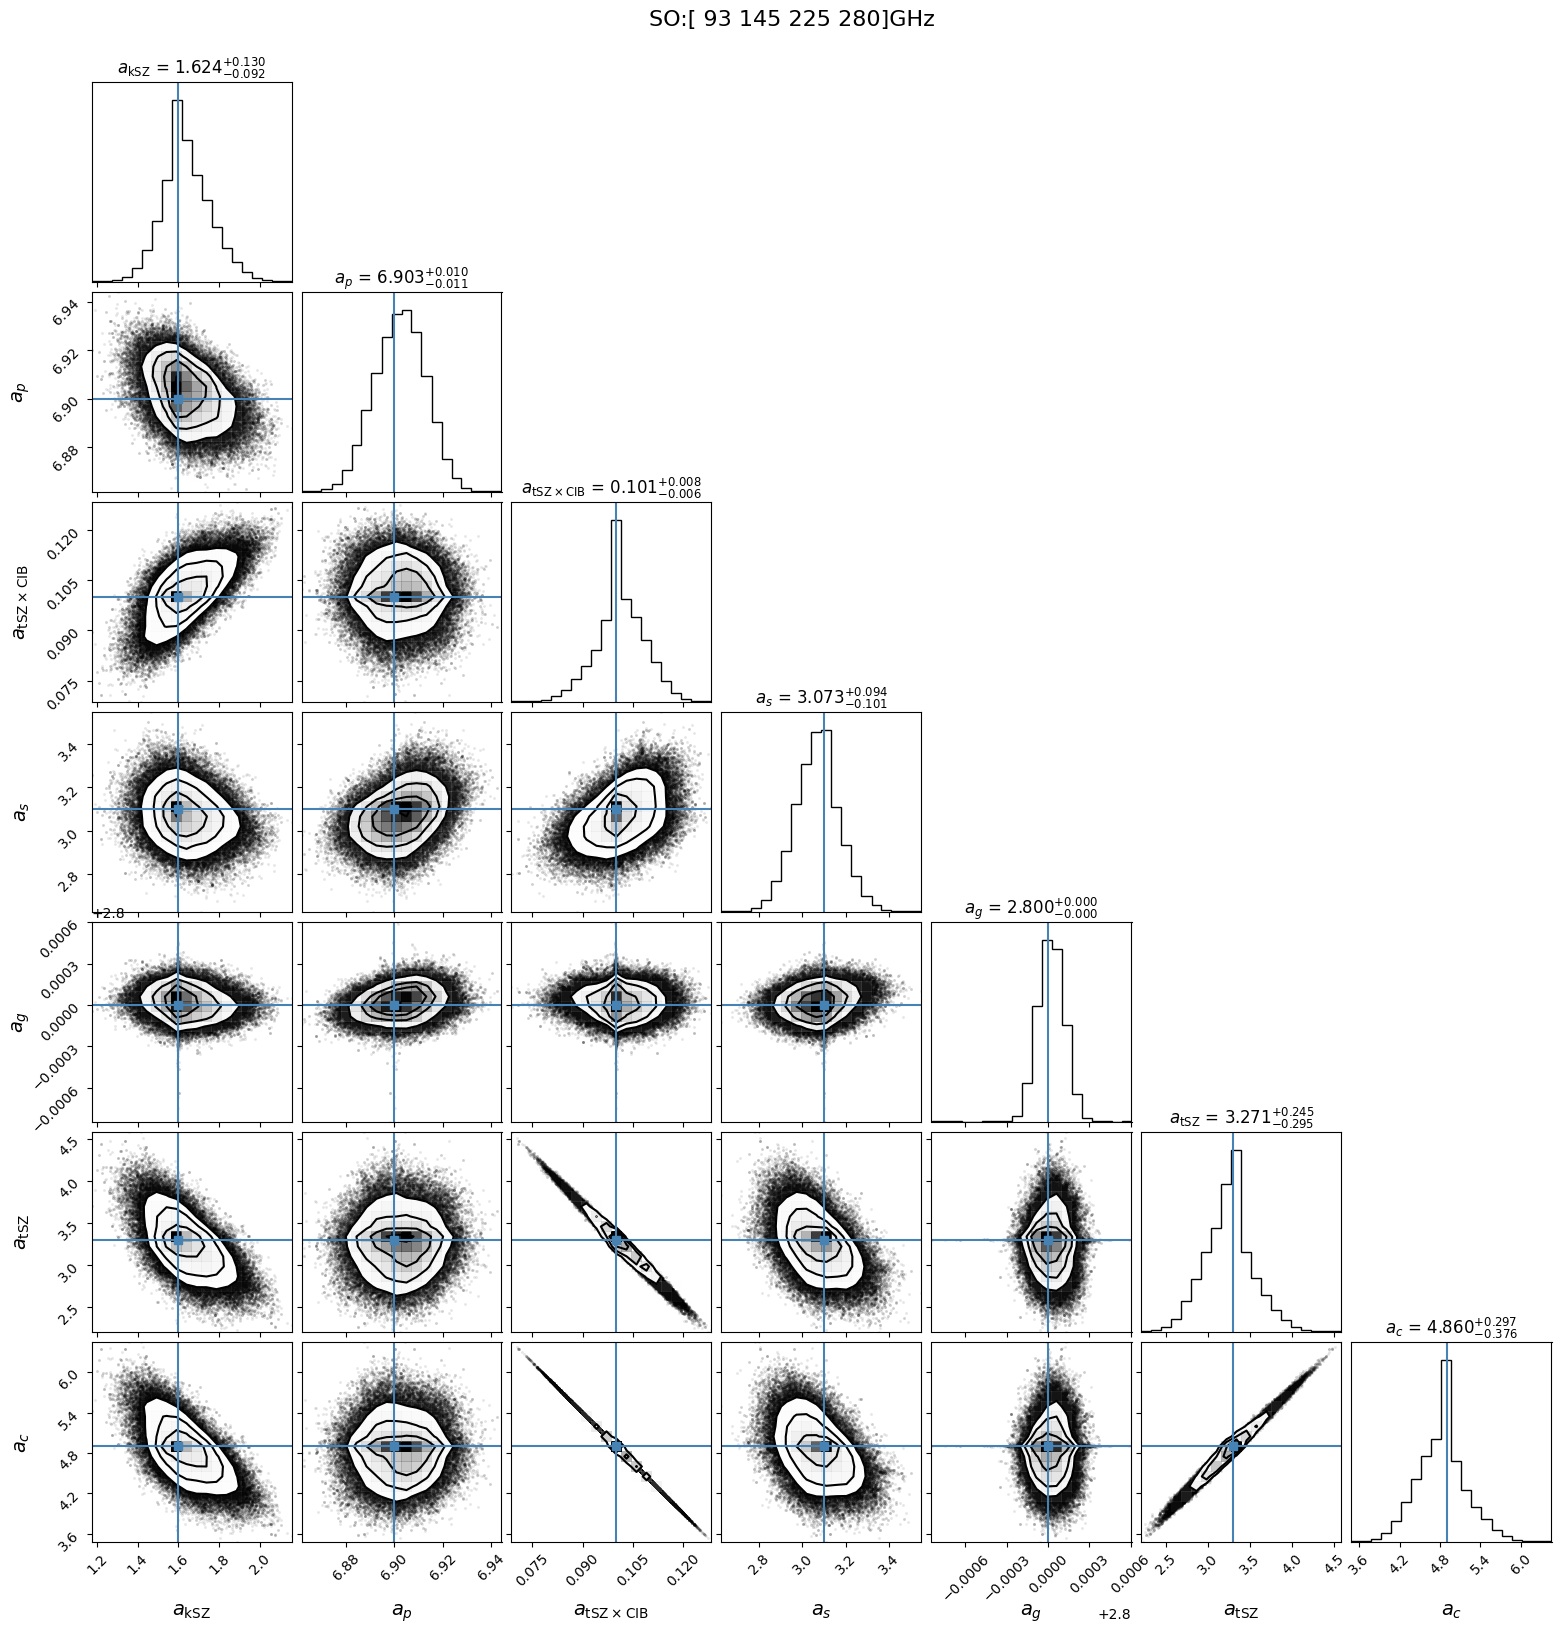

In [11]:
combined_samples = np.vstack(samples_list)
#Plot the corner with truths and titles
figure = corner.corner(
    combined_samples,
    labels=labels,
    truths=a_true,
    label_kwargs={"fontsize": 14},
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)
plt.suptitle(f"SO:{so_freqs}GHz", fontsize=16, y=1.02)

In [19]:
samples_listo = []
p_means_listo = []
p_stds_listo = []
for i in range(20):
    this_sampleso, this_p_meanso, this_p_stdso = run_emcee(C_b_offset, plot=False)
    samples_listo.append(this_sampleso)
    p_means_listo.append(this_p_meanso)
    p_stds_listo.append(this_p_stdso)
    print(i+1)

combined_sampleso = np.vstack(samples_listo)


100%|██████████| 2000/2000 [01:11<00:00, 28.00it/s]


1


100%|██████████| 2000/2000 [01:25<00:00, 23.44it/s]


2


100%|██████████| 2000/2000 [02:14<00:00, 14.83it/s]


3


100%|██████████| 2000/2000 [01:29<00:00, 22.23it/s]


4


100%|██████████| 2000/2000 [01:24<00:00, 23.69it/s]


5


100%|██████████| 2000/2000 [01:19<00:00, 25.22it/s]


6


100%|██████████| 2000/2000 [01:50<00:00, 18.15it/s]


7


100%|██████████| 2000/2000 [01:06<00:00, 30.12it/s]


8


100%|██████████| 2000/2000 [00:57<00:00, 35.03it/s]


9


100%|██████████| 2000/2000 [01:17<00:00, 25.96it/s]


10


100%|██████████| 2000/2000 [01:35<00:00, 20.90it/s]


11


100%|██████████| 2000/2000 [01:17<00:00, 25.91it/s]


12


100%|██████████| 2000/2000 [01:09<00:00, 28.92it/s]


13


100%|██████████| 2000/2000 [01:13<00:00, 27.09it/s]


14


100%|██████████| 2000/2000 [01:19<00:00, 25.21it/s]


15


100%|██████████| 2000/2000 [01:14<00:00, 26.90it/s]


16


100%|██████████| 2000/2000 [01:09<00:00, 28.65it/s]


17


100%|██████████| 2000/2000 [01:12<00:00, 27.72it/s]


18


100%|██████████| 2000/2000 [01:45<00:00, 18.94it/s]


19


100%|██████████| 2000/2000 [01:17<00:00, 25.73it/s]


20


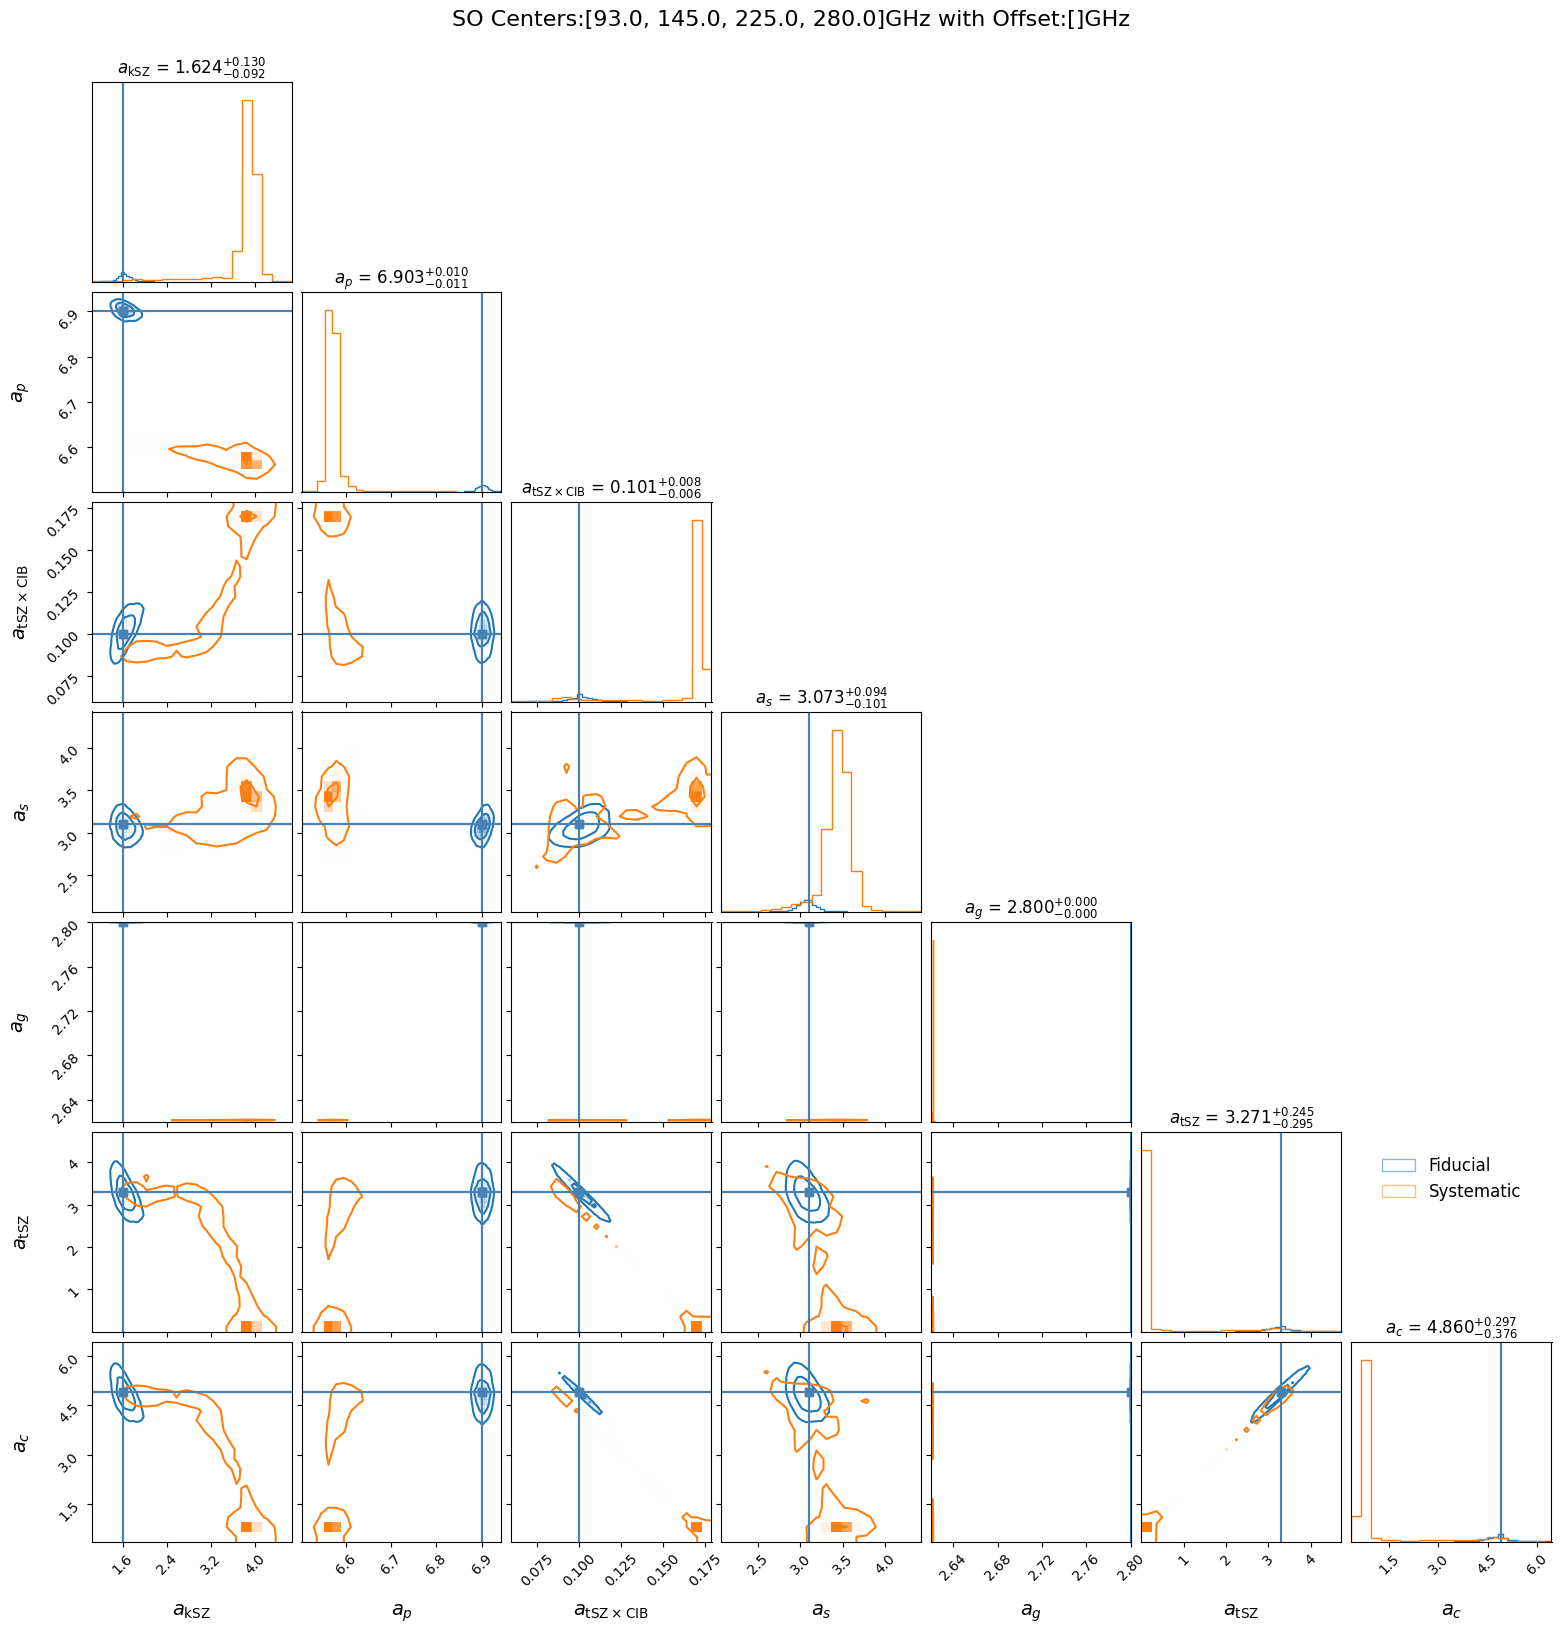

In [20]:

figure = corner.corner(
    combined_samples,
    labels=labels,
    truths=a_true,
    label_kwargs={"fontsize": 14},
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
    color="C0",
    plot_datapoints=False,
    fill_contours=False,
    levels=(0.68, 0.95),
    alpha=0.5
)

# Overlay second plot (e.g., comparison)
corner.corner(
    combined_sampleso,
    labels=labels,
    truths=a_true,
    label_kwargs={"fontsize": 14},
    show_titles=False,  # avoid duplicated titles
    color="C1",
    plot_datapoints=False,
    fill_contours=False,
    levels=(0.68, 0.95),
    fig=figure
)
handles = [
    Patch(facecolor='none', edgecolor='C0', label="Fiducial", alpha=0.5),
    Patch(facecolor='none', edgecolor='C1', label="Systematic", alpha=0.5)
]
plt.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 2),#bbox_to_anchor=(0.5, 4),  # x, y (move y negative to shift down)
    ncol=1,
    fontsize=12,
    frameon=False
)
plt.suptitle(f"SO Centers:{centerfreqs.tolist()}GHz with Offset:{ccat_offset}GHz", fontsize=16, y=1.02)
plt.show()

In [14]:
samples_listg = []
p_means_listg = []
p_stds_listg = []
for i in range(4):
    this_samplesg, this_p_meansg, this_p_stdsg = run_emcee_gauss(offsets=None, mu_array=None, sigma_array=None, plot=False)
    samples_listg.append(this_samplesg)
    p_means_listg.append(this_p_meansg)
    p_stds_listg.append(this_p_stdsg)
    print(i+1)

100%|██████████| 500/500 [1:52:59<00:00, 13.56s/it]


1
emcee: Exception while calling your likelihood function:
  params: [ 1.60330930e+00  6.89283389e+00  1.05153506e-01  3.09765557e+00
  2.78633457e+00  3.29577768e+00  4.89437758e+00 -1.23624549e-02
  2.14960755e-02 -4.90773909e-03  5.16556294e-03]
  args: (array([-2.74958384e+02,  2.11244403e+01,  1.23297421e+02,  3.21238086e+02,
        8.92693923e+01,  3.74029284e+02,  9.67604512e+02,  1.58871402e+03,
        4.10177040e+03,  1.05896676e+04,  4.34537821e+00,  1.24587671e+01,
        5.05659481e+01,  1.31050263e+02,  3.64487862e+01,  1.52722292e+02,
        3.93673391e+02,  6.46645908e+02,  1.67058756e+03,  4.31072344e+03,
        4.13018311e+00,  9.05715199e+00,  3.60133139e+01,  9.05708498e+01,
        2.58429949e+01,  1.06135372e+02,  2.72610050e+02,  4.48696865e+02,
        1.15789166e+03,  2.98566870e+03,  2.57505043e+00,  6.98457705e+00,
        2.72117107e+01,  6.96179601e+01,  2.04215777e+01,  8.27339315e+01,
        2.11788714e+02,  3.49086121e+02,  9.00190381e+02,  2.319629

Traceback (most recent call last):
  File "/root/.pyenv/versions/3.10.4/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_500516/1187912811.py", line 44, in log_probabilityg
    return lp + log_likelihoodg(theta, data, cov_inv, logdet, offsets)
  File "/tmp/ipykernel_500516/1187912811.py", line 18, in log_likelihoodg
    C_b_shifted = rebin_C(get_fg_model(shifted_freqs, ells, par))
  File "/tmp/ipykernel_500516/3502664036.py", line 62, in rebin_C
    tC_b[s][f1, f2][i] = np.mean(tC_l[s][f1, f2][lrange]) / a_true[s]
  File "/root/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/fromnumeric.py", line 3504, in mean
    return _methods._mean(a, axis=axis, dtype=dtype,
  File "/root/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/core/_methods.py", line 118, in _mean
    ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
KeyboardInterrupt


KeyboardInterrupt: 

Text(0.5, 1.02, 'SO:[ 93 145 225 280]GHz')

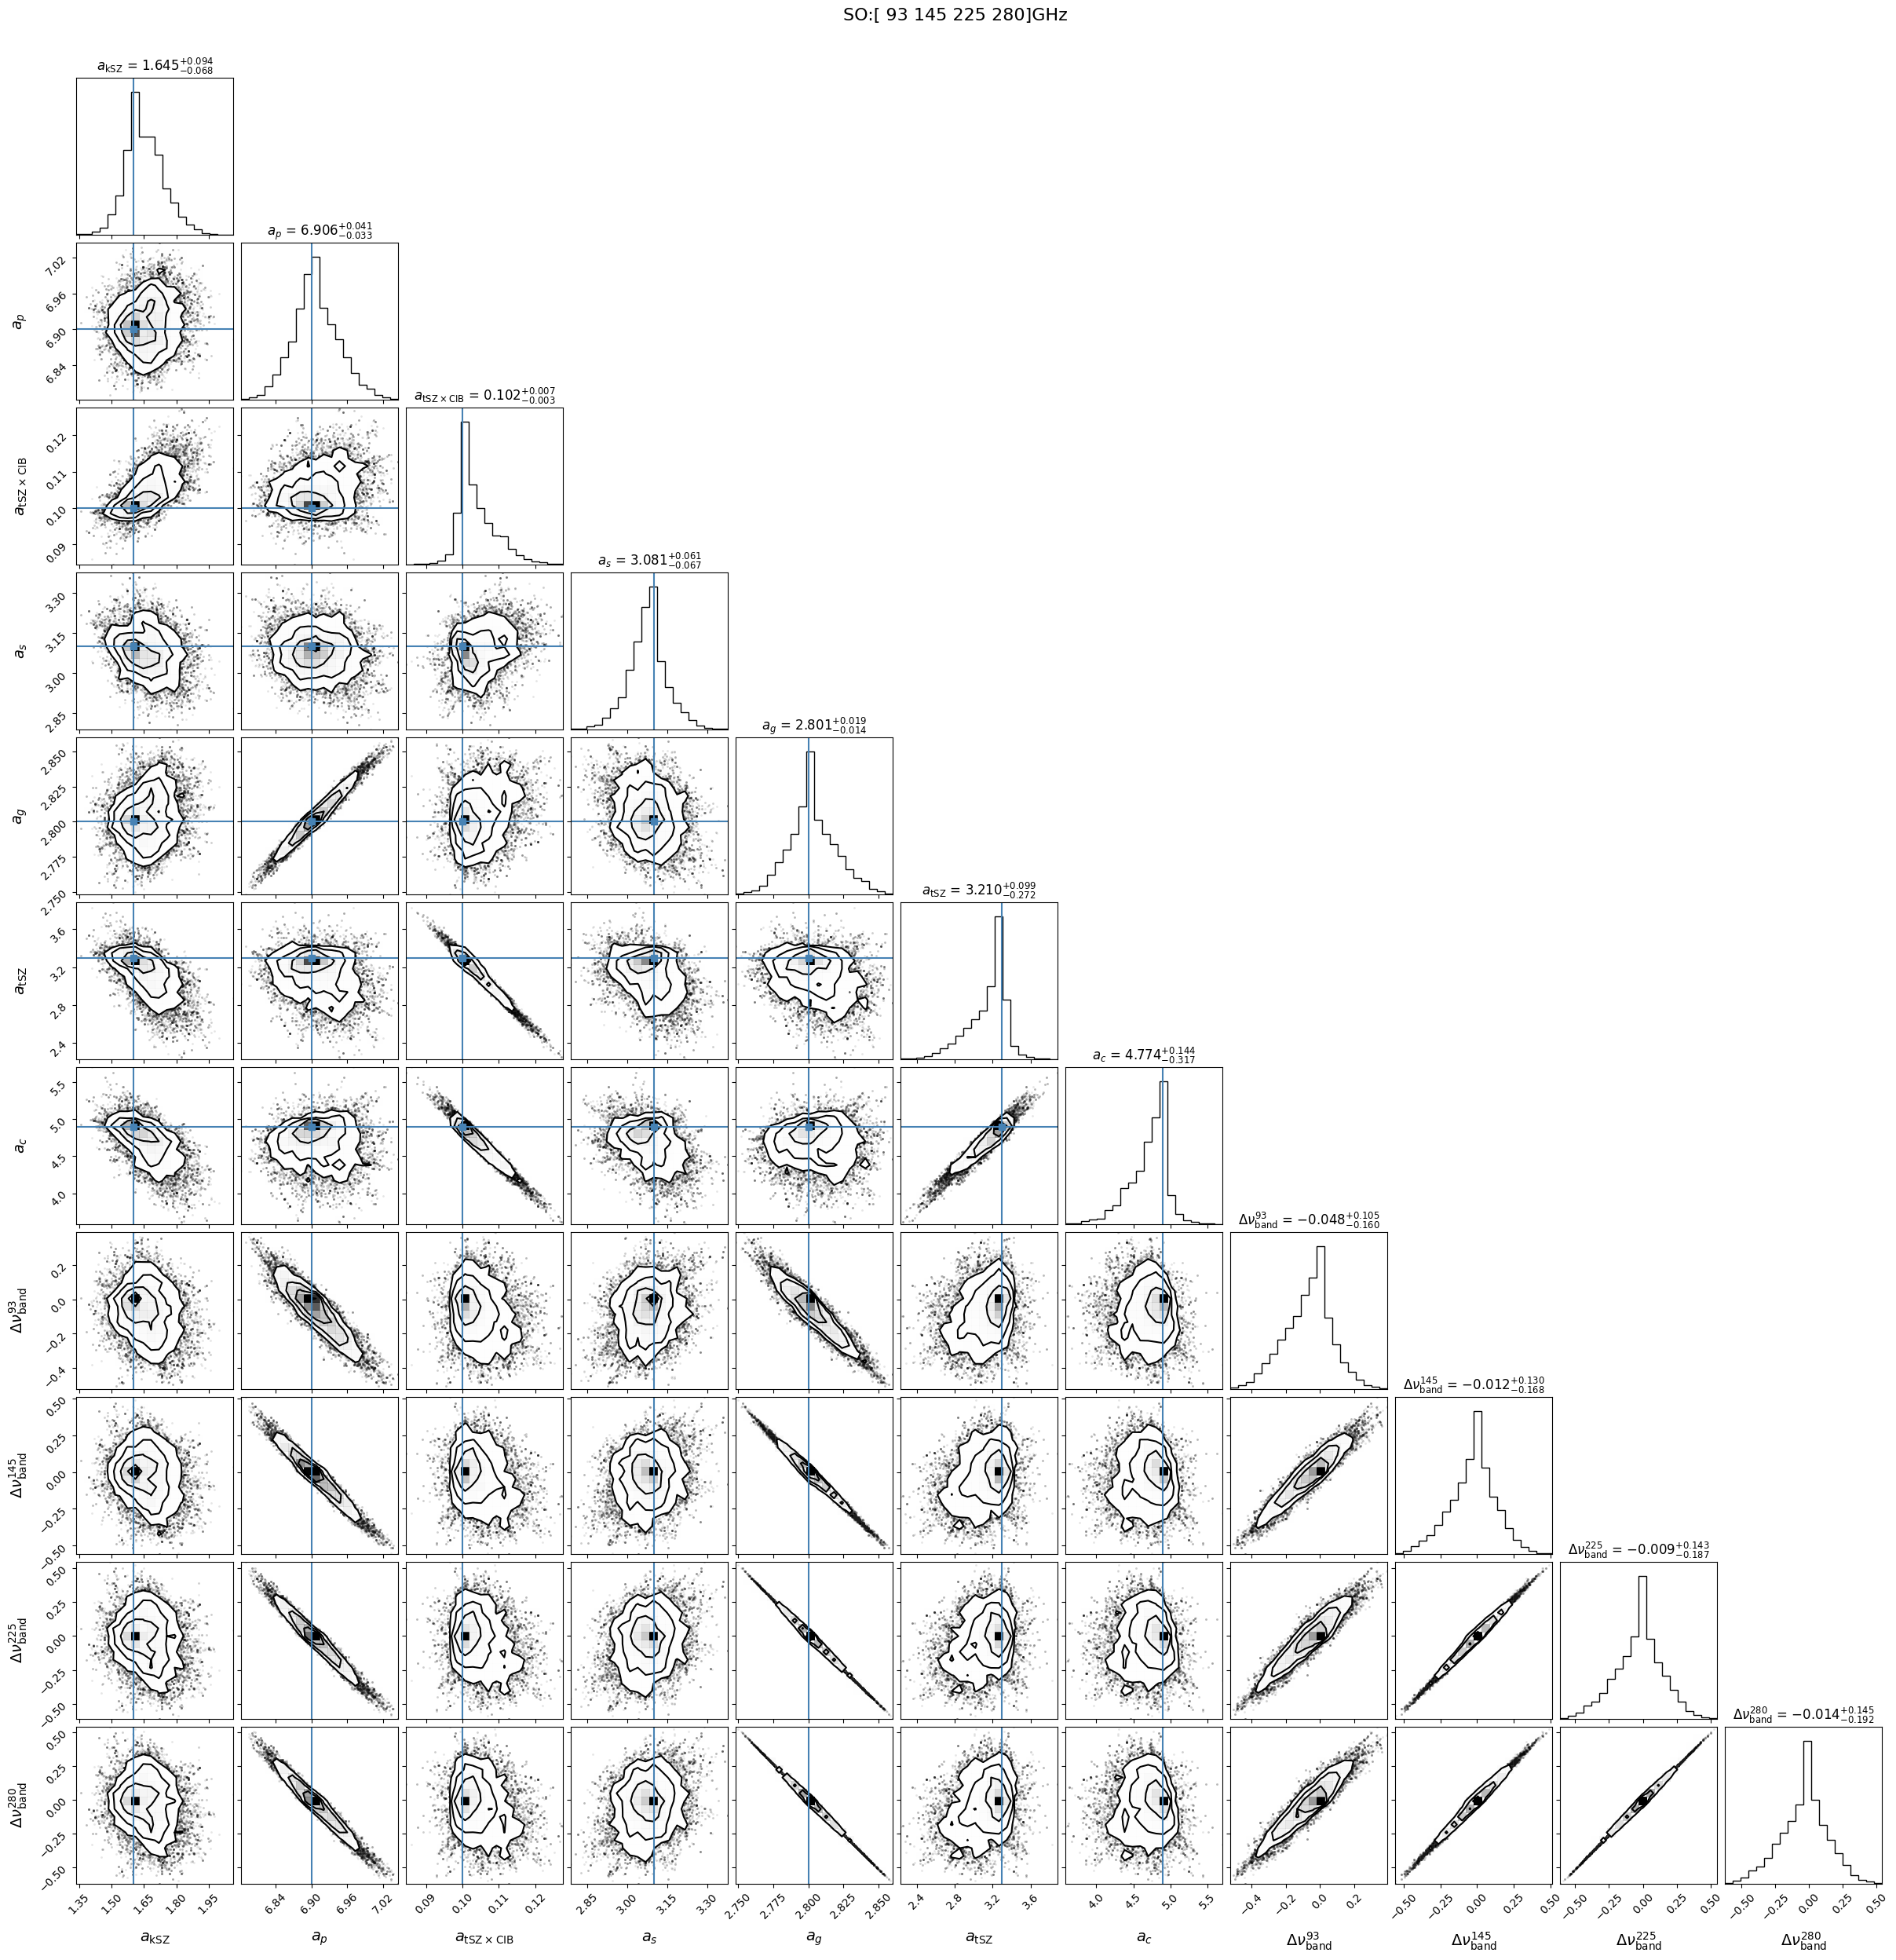

In [15]:
combined_samplesg = np.vstack(samples_listg)
#Plot the corner with truths and titles
figure = corner.corner(
    combined_samplesg,
    labels=labels_f,
    truths=a_true_f,
    label_kwargs={"fontsize": 14},
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)
plt.suptitle(f"SO:{so_freqs}GHz", fontsize=16, y=1.02)

In [ ]:
# samples_listg2 = []
# p_means_listg2 = []
# p_stds_listg2 = []
# for i in range(1):
#     this_samplesg2, this_p_meansg2, this_p_stdsg2 = run_emcee_gauss(offsets=offset, mu_array=None, sigma_array=None, plot=True)
#     samples_listg2.append(this_samplesg2)
#     p_means_listg2.append(this_p_meansg2)
#     p_stds_listg2.append(this_p_stdsg2)
#     print(i+1)


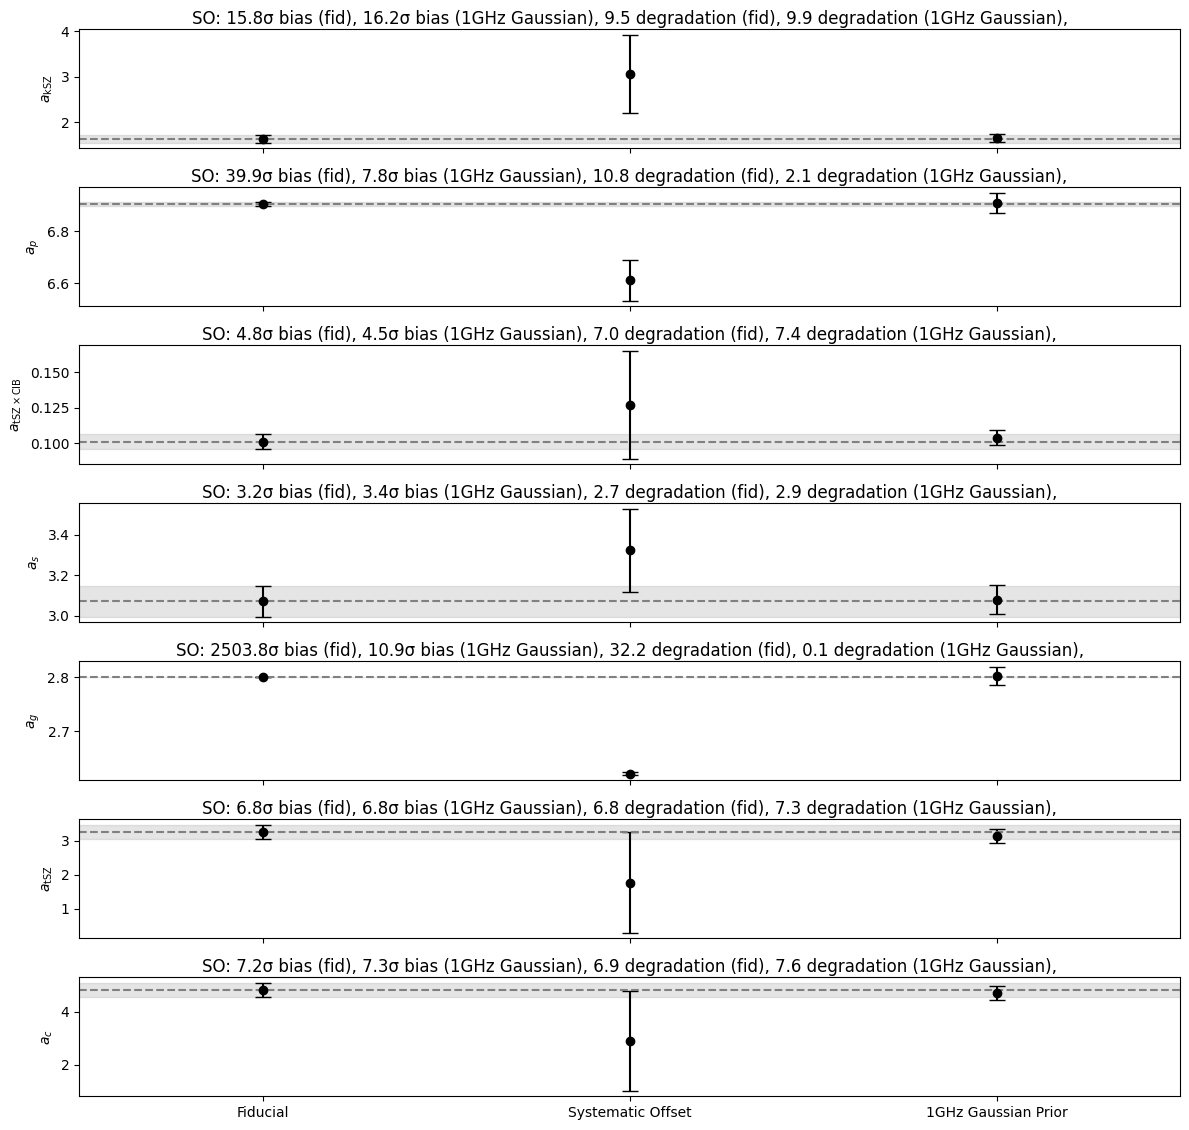

In [16]:

fiducial_mean = np.mean(p_means_list, axis=0)
systematic_mean = np.mean(p_means_listo, axis=0)
gp_mean = np.mean(p_means_listg, axis=0)[:-4]

fiducial_std = np.mean(p_stds_list, axis=0)
systematic_std = np.mean(p_stds_listo, axis=0)
gp_std = np.mean(p_stds_listg, axis=0)[:-4]

bias_fid = np.abs(systematic_mean - fiducial_mean) / fiducial_std
bias_gp = np.abs(systematic_mean - gp_mean) / gp_std
degradation_fid = systematic_std/fiducial_std
degradation_gp = systematic_std/gp_std

param_names = labels
syslabels = ["Fiducial", "Systematic Offset", "1GHz Gaussian Prior"]
x = np.arange(len(syslabels))

fig, axes = plt.subplots(n_fore,1,figsize=(12, 12), sharex=True)
axes = axes.flatten()


for i in range(len(labels)):
    ax = axes[i]

    y_vals = [fiducial_mean[i], systematic_mean[i], gp_mean[i]]
    y_errs = [fiducial_std[i], systematic_std[i], gp_std[i]]

    # Plot error bars
    ax.errorbar(x, y_vals, yerr=y_errs, fmt='o', capsize=6, color='black')

    # Fiducial horizontal line and shaded uncertainty band
    ax.axhline(fiducial_mean[i], color='gray', linestyle='dashed', label='Fiducial')
    ax.fill_between([-0.5, 2.5],
                    fiducial_mean[i] - fiducial_std[i],
                    fiducial_mean[i] + fiducial_std[i],
                    color='gray', alpha=0.2)

    
    # Annotate bias
    ax.text(0.5, 1.01, f"SO: {bias_fid[i]:.1f}σ bias (fid), {bias_gp[i]:.1f}σ bias (1GHz Gaussian), {degradation_fid[i]:.1f} degradation (fid), {degradation_gp[i]:.1f} degradation (1GHz Gaussian),",
        transform=ax.transAxes,
        ha='center', va='bottom', fontsize=12, color='black')
    
    #ax.text(0.1, 1.01,"SO",ha='center', va='bottom', fontsize=12, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(syslabels)
    ax.set_ylabel(param_names[i])
    ax.set_xlim(-0.5, 2.5)
    #ax.legend()

#fig.suptitle("Parameter Comparison: Fiducial vs Systematic", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
for f in range(n_freq):
    #for s in range(n_fore):
        #plt.plot(C_b[s][(f,f)]*fiducial_mean[s], label=labels[s], color=dcolors[s])
        #plt.plot(C_b_offset[s][(f,f)], label=f"{labels[s]} offset by {offset[f]} GHz", color=dcolors[s])
    C_total = sum(C_b[s][f, f]*fiducial_mean[s] for s in range(n_fore))
    C_totalo = sum(C_b[s][f, f]*systematic_mean[s] for s in range(n_fore))
    plt.plot(C_total, label="sum fg templates*fiducial posterior means")
    plt.plot(C_totalo, label="sum fg templates*systematic posterior means")
    plt.plot(N_b[f], label="noise", color='black')
    plt.legend(loc = 'upper right')
    plt.yscale('log')
    #plt.xlim(-500,9000)
    #plt.ylim(10e-3,10e3)
    plt.title(f"Auto spectra at {centerfreqs[f]}")
    plt.gca().set_box_aspect(1)
    plt.show()
